# Image Data Compression and K-Means

In this notebook, we will explore the three main matrix decomposition methods (PCA, NMF, and KMeans) and apply them to the problem of image compression. Our running example will be "Lena" AKA "Lenna", an image that has become a classic in the image processing community.

In [1]:
# For image processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA, NMF

## Step 0: Importing  and Reshaping the Data

A color image can be thought of as a three dimensional array of values. These dimensions are the horizontal position of the pixel ($x$), the vertical dimension of the pixel ($y$), and the channel (red, green, or blue). 

In [2]:
# Import lena_3D_arr
lena_3D_arr = plt.imread('lena.png')

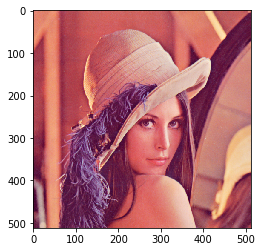

In [3]:
# Reshape the image by manipulating lena_3D_arr
# Use the existing lena_3D_arr object
lena_3D_arr = lena_3D_arr * 255
lena_3D_arr = lena_3D_arr.astype(int)
gold_lena_3D_arr = lena_3D_arr

plt.imshow(lena_3D_arr);

In [4]:
x_size, y_size, channels = lena_3D_arr.shape
lena_2D_arr = lena_3D_arr.reshape(x_size*y_size, channels)

## Step 1: Scaling the Data

You may notice that the colors seem out of balance. This is a reminder that the datasets will commonly have differing ranges of values among their features. We will cover two main ways to address this.

### Step 1.1: Minmax Scaling

The simpler of the two approaches linearly maps the values to the real numbers between 0 and 1. We'll implement this in two ways. The first step in each function is to create a deep copy of the image using `image.copy()`. Then,

1. Minmax scaling by hand. In this function, we divide each value of `image` by the size of the original range of values in `image`. Then subtract off the new minimum.
2. Use the minmax scaler. We will need to cast the `image` to floats.

Afterwards, in each of these functions, we multiply the resulting image by 255 and cast the values to integers.

In [5]:
def rescale_2D(image):
    new_image = image.copy()
    range = np.max(new_image) - np.min(new_image)
    new_image = new_image/range
    new_min = np.min(new_image)
    new_image = new_image - new_min
    
    new_image = new_image * 255
    new_image = new_image.astype(int)
    
    return new_image

def minmax_image(image):
    new_image = image.copy()
    
    scaler = preprocessing.MinMaxScaler()
    
    for i in range(image.shape[1]):
        new_image[:,i] = (scaler.fit_transform(new_image[:,i].astype(float).reshape(-1, 1))*255).astype(int).reshape(512*512,)
        
    return new_image

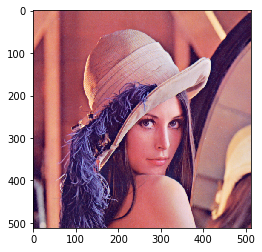

In [6]:
minmax_lena_2D_arr = minmax_image(lena_2D_arr)
minmax_lena_3D_arr = minmax_lena_2D_arr.reshape(x_size, y_size, channels)
plt.imshow(minmax_lena_3D_arr);

### Step 1.2: Standard Scaling

Now, we define a new function `standard_image(image)`. As before, we first make a deep copy of the image. Then, apply the standard scaler. As before, we will need to cast the image to floats.

This scaler subtracts the mean and divides by the standard deviation, essentially converting the values of your dataset into $z$-scores. Therefore, we can expect values between $-3$ and $3$. As such, we will need to apply `rescale_2D()` to the resultant values before displaying the scaled image.

In [7]:
def standard_image(image):
    new_image = image.copy()
    
    sts = preprocessing.StandardScaler()
    new_image = sts.fit_transform(new_image.astype(float))
    
    return new_image 

In [8]:
standard_lena_2D_arr = standard_image(lena_2D_arr)
standard_lena_2D_arr = rescale_2D(standard_lena_2D_arr)
standard_lena_3D_arr = standard_lena_2D_arr.reshape(x_size, y_size, channels)

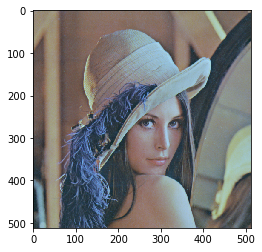

In [9]:
plt.imshow(standard_lena_3D_arr);

## Step 2: Matrix Decomposition

Now that we have scaled the data, it is time to consider dimensionality reduction via matrix decomposition.

### Step 2.1: PCA

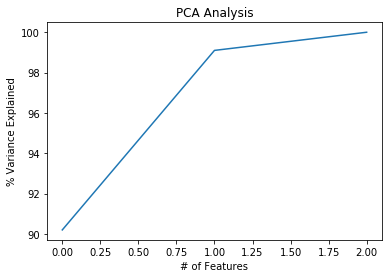

In [10]:
X_forExploringPCA = lena_2D_arr.copy()
pca_model = PCA(n_components = 3)
pca_model.fit(X_forExploringPCA)
variance = pca_model.explained_variance_ratio_ #calculate variance ratios                                         

var = np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features                                                          

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)

The above graph shows that we really don't have too many options when it comes to number of PCA dimensions. In fact, there are really only two reasonable values. In the cell below, I assign a value to `cutoff` for an appropriate number of PCA dimensions.

In [11]:
cutoff = 2

We will define the function `pca_lena(data, n_components)` below. This function will make a deep copy of the dataset, initialize a PCA model, and run the decomposition. What the function returns are the three truncated SVD matrices. For example:

`U, np.diag(model.singular_values_), model.components_`

where, `U` is the first matrix of orthogonal columns, `np.diag(model.singular_values_)` is the middle, diagonal matrix, and `model.components_` is the last, invertible matrix.

In [12]:
def pca_lena(data, n_components):
    new_data = data.copy()
        
    pca = PCA(n_components=n_components)
    pca.fit(new_data)
    U = pca.transform(new_data).dot(np.linalg.inv(np.diag(pca.singular_values_)))
    
    return U, np.diag(pca.singular_values_), pca.components_

In [13]:
pca_lena_2D_arr = rescale_2D(pca_lena(standard_lena_2D_arr, 2)[0] @ pca_lena(standard_lena_2D_arr, 2)[1] @ pca_lena(standard_lena_2D_arr, 2)[2])
pca_lena_3D_arr = pca_lena_2D_arr.reshape(x_size, y_size, channels)

another_pca_lena_2D_arr = rescale_2D(pca_lena(standard_lena_2D_arr, 1)[0] @ pca_lena(standard_lena_2D_arr, 1)[1] @ pca_lena(standard_lena_2D_arr, 1)[2])
another_pca_lena_3D_arr = another_pca_lena_2D_arr.reshape(x_size, y_size, channels)

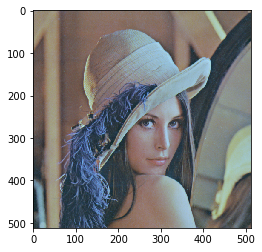

In [14]:
# Without PCA
plt.imshow(standard_lena_3D_arr);

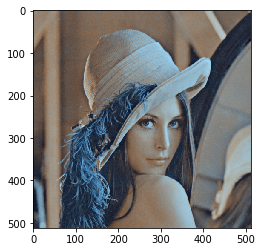

In [15]:
# PCA with 2 principal components
plt.imshow(pca_lena_3D_arr);

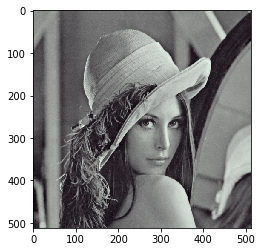

In [16]:
# PCA with 1 principal component
plt.imshow(another_pca_lena_3D_arr);

### Step 2.2: NMF

As shown in the PCA section, orthogonal colors is an unreasonable requirement for an image representations. Therefore, we will also use NMF and compare the results. As before, we will define a `nmf_lena(data, n_components)` function. This function will create a deep copy of the data, initialize the model with `init='random'` and `random_state=0`, and then run the decomposition. The function returns the items by components matrix ($W$) and the components by features matrix ($H$, here named `model.components_`). For example:

`W, model.components_`


In [17]:
def nmf_lena(data, n_components):
    new_data = data.copy()
    
    nmf = NMF(n_components=n_components, init='random', random_state=0)
    nmf.fit(new_data)
    
    return nmf.transform(new_data), nmf.components_

In [18]:
nmf_lena_2D_arr = rescale_2D(nmf_lena(standard_lena_2D_arr, 2)[0] @ nmf_lena(standard_lena_2D_arr, 2)[1])
nmf_lena_3D_arr = nmf_lena_2D_arr.reshape(x_size, y_size, channels)

another_nmf_lena_2D_arr = rescale_2D(nmf_lena(standard_lena_2D_arr, 1)[0] @ nmf_lena(standard_lena_2D_arr, 1)[1])
another_nmf_lena_3D_arr = another_nmf_lena_2D_arr.reshape(x_size, y_size, channels)

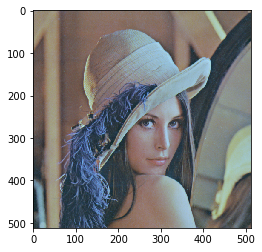

In [19]:
# Without NMF
plt.imshow(standard_lena_3D_arr);

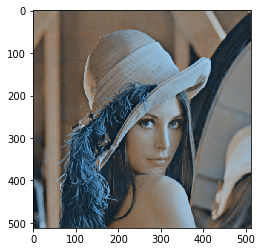

In [20]:
# NMF with 2 components
plt.imshow(nmf_lena_3D_arr);

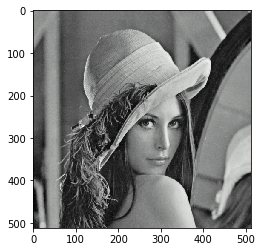

In [21]:
# NMF with 1 component
plt.imshow(another_nmf_lena_3D_arr);

## Step 3: K-means

So far, we have achieved a compression rate of approximately 1.5 to 1. So let's see if we can beat that with clustering. We will first test on small $k$ values and then visualize larger ones.

We will try to find the "elbow" indicating a possibly optimal number of clusters. Running $k$-means on over 200,000 items can be rather time consuming, so we will just carefully evaluate up to 8 clusters.

### Step 3.1: The Original Image

In the cell below, we define a function called `test_cluster_size` that iterates over the numbers of clusters in the array `num_clusters`. The function takes as input (1) the data as a matrix and (2) the `num_clusters` array, and returns a list of scores.

In [22]:
def test_cluster_size(data, num_clusters, components=None):
    max_cluster = []
    for i in num_clusters:
        km = KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=10, tol=1e-4, random_state=0, n_jobs=1)
        km.fit(data)
        
        new_arr = np.zeros(data.shape)
        for j in range(data.shape[0]):
            new_arr[j] = km.cluster_centers_.astype(int)[km.labels_[j]]
        
        dist = np.sum(np.square(data - new_arr))
        max_cluster.append(int(dist))
        
    return max_cluster

num_clusters = [2,3,4,5,6,7,8]
ssws31 = test_cluster_size(lena_2D_arr, num_clusters)

In [23]:
display(ssws31)

[607357036, 338591894, 214597835, 166902784, 137712092, 119082873, 104913689]

### Step 3.2: The Standard Image

Let's apply the function again, this time to the image after "standard" scaling.

In [24]:
num_clusters = [2,3,4,5,6,7,8]
ssws32 = test_cluster_size(standard_lena_2D_arr, num_clusters)
display(ssws32)

[491298224, 277324442, 179252956, 143165073, 114665530, 101799950, 89852029]

### 3.3: Finding the Elbow

The following code helps plot the number of clusters (from 2 to 8) versus $SS_W$.

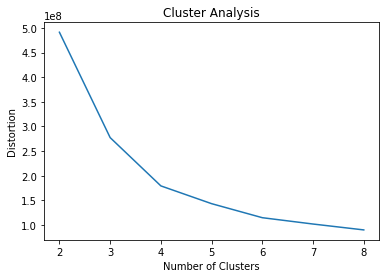

I have chosen to have 4 clusters.


In [25]:
def plot_clusters(num_clusters, distortions):
    plt.figure()
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Cluster Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(num_clusters, distortions)
    plt.show()

plot_clusters(num_clusters, ssws32)
khat33 = 4

print("I have chosen to have", khat33, "clusters.")

## Step 4: The Variance Ratio Criterion

Recall the Variance Ratio Criterion ($VRC$), given by

$$ VRC(k) = \frac{SS_B}{k-1} / \frac{SS_W}{N - k}$$

where $SS_B$ is the sum of squared distance between the cluster centers and the grand mean (calculated per data point), $k$ is the number of clusters, $SS_W$ is the sum of squared distance between data points and their assigned cluster centers, and $N$ is the number of data points.


### Step 4.1: The Grand Mean

In [26]:
original_grand_mean = np.mean(lena_2D_arr, axis=0)
min_max__grand_mean = np.mean(minmax_lena_2D_arr, axis=0)
standard_grand_mean = np.mean(standard_lena_2D_arr, axis=0)

array([180.22365952,  99.05121613, 105.41025162])

array([159.63759613,  99.47625732, 113.9680481 ])

array([113.97200775, 113.96060562, 113.9680481 ])

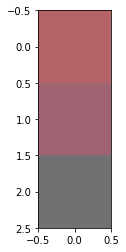

In [27]:
display(original_grand_mean, min_max__grand_mean, standard_grand_mean)
plt.figure()
plt.imshow([[original_grand_mean/255], [min_max__grand_mean/255], [standard_grand_mean/255]])

### Step 4.2 Implementing VRC

We will write a function `test_vrc(data, max_num_cluster)` that computes the $VRC$ on clusterings of size 2 up to size `max_num_cluster`. 

In [28]:
def test_vrc(data, num_clusters):
    max_cluster = []
    grand_mean = np.mean(data, axis=0)

    for i in num_clusters:
        km = KMeans(n_clusters=i, init='k-means++', n_init=30, max_iter=10, tol=1e-4, random_state=0, n_jobs=1)
        km.fit(data)
        ssw = km.inertia_
        
        new_arr = np.zeros(data.shape)
        for j in range(data.shape[0]):
            new_arr[j] = km.cluster_centers_[km.labels_[j]]
        
        ssb = np.sum(np.square(new_arr - grand_mean))
        vrc = (ssb/(i-1))/(ssw/(data.shape[0]-i))
        
        max_cluster.append(vrc)
        
    return max_cluster

In [29]:
num_clusters = [2,3,4,5,6,7,8]
vrcs43 = test_vrc(standard_lena_2D_arr, num_clusters)

### Step 4.3: Selecting a number of clusters with VRC

We will plot the number of clusters (from 2 to 8) versus $VRC$, and set $\hat{k}_{VRC}$ to the number of clusters recommended by $VRC$.

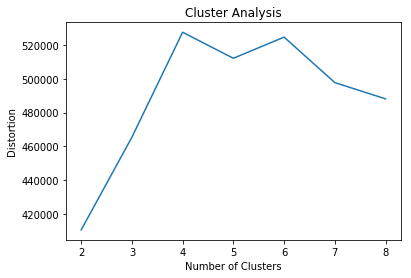

I have chosen to have 4 clusters.


In [30]:
plot_clusters(num_clusters, vrcs43)

khat43 = 4

print("I have chosen to have", khat43, "clusters.")

## Step 5: More Clusters and Summary

The code below runs kmeans with the values 16, 32, and 64 on `standard_lena_2D_arr` and displays the resulting images.

In [31]:
ssws33 = test_cluster_size(standard_lena_2D_arr, [16,32,64])

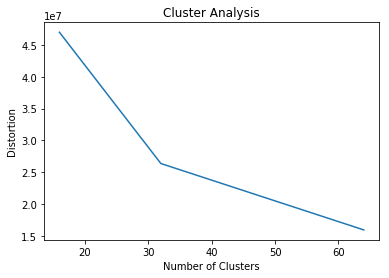

In [32]:
plot_clusters([16,32,64], ssws33)

In [33]:
def cluster_image(data, num_clusters):
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=30, max_iter=10, tol=1e-4, random_state=0, n_jobs=1)
    km.fit(data)
    
    new_arr = np.zeros(data.shape)
    for i in range(data.shape[0]):
        new_arr[i] = km.cluster_centers_.astype(int)[km.labels_[i]]
        
    plt.imshow(new_arr.reshape(x_size, y_size, channels).astype(int));

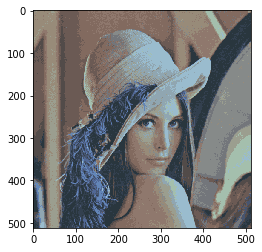

In [34]:
# 16 clusters
cluster_image(standard_lena_2D_arr, 16)

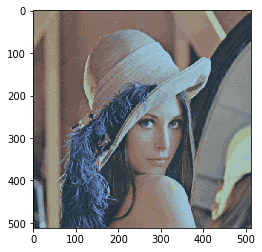

In [35]:
# 32 clusters
cluster_image(standard_lena_2D_arr, 32)

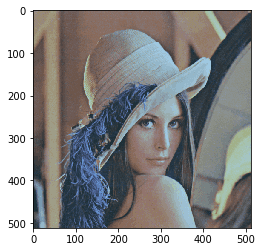

In [36]:
# 64 clusters
cluster_image(standard_lena_2D_arr, 64)

The code below summarizes all of the outputs that we have generated in this notebook.

In [37]:
print("lena_3D_arr.shape is", lena_3D_arr.shape)
print("lena_2D_arr.shape is", lena_2D_arr.shape)
print("minmax_lena_3D_arr is", minmax_lena_3D_arr.shape)
print("standard_lena_3D_arr.shape is", standard_lena_3D_arr.shape)
print("cutoff is", cutoff)
print("pca_lena_3D_arr.shape is", pca_lena_3D_arr.shape)
print("nmf_lena_3D_arr.shape is", nmf_lena_3D_arr.shape)
print("The SSWs I got in 3.1 are", ssws31)
print("The SSWs I got in 3.2 are", ssws32)
print("The khat I chose in 3.3 is", khat33)
print("The grand mean of original Lena is", original_grand_mean)
print("The khat I chose in 4.3 is", khat43)

lena_3D_arr.shape is (512, 512, 3)
lena_2D_arr.shape is (262144, 3)
minmax_lena_3D_arr is (512, 512, 3)
standard_lena_3D_arr.shape is (512, 512, 3)
cutoff is 2
pca_lena_3D_arr.shape is (512, 512, 3)
nmf_lena_3D_arr.shape is (512, 512, 3)
The SSWs I got in 3.1 are [607357036, 338591894, 214597835, 166902784, 137712092, 119082873, 104913689]
The SSWs I got in 3.2 are [491298224, 277324442, 179252956, 143165073, 114665530, 101799950, 89852029]
The khat I chose in 3.3 is 4
The grand mean of original Lena is [180.22365952  99.05121613 105.41025162]
The khat I chose in 4.3 is 4


---

Note: This is one of the assignments of CIS 545 Big Data Analytics at University of Pennsylvania during Spring 2019.